In [16]:
import os
import numpy as np
from PIL import Image

# Use the current directory for images.
datafolder = "."

# List all files with the .gif extension (case-insensitive)
all_files = os.listdir(datafolder)
names = [file for file in all_files if file.lower().endswith('.gif')]

# Set to collect unique values across all images.
overall_unique = set()

# Process each image.
for file in names:
    file_path = os.path.join(datafolder, file)
    with Image.open(file_path) as img:
        try:
            # For animated images, read only the first frame.
            img.seek(0)
        except EOFError:
            pass
        # Convert the image to a numpy array without any conversion.
        img_array = np.array(img)
    
    # Find unique pixel values in the image.
    unique_vals = np.unique(img_array)
    print(f"Unique values in {file}: {unique_vals}")
    
    # Update the overall set of unique values.
    overall_unique.update(unique_vals.flatten())

# Print the overall unique values sorted.
overall_unique_sorted = sorted(list(overall_unique))
print("Overall unique values across all images:")
print(overall_unique_sorted)


Unique values in children-3.gif: [0 1]
Unique values in face-5.gif: [0 1]
Unique values in watch-9.gif: [0 1]
Unique values in apple-5.gif: [0 1]
Unique values in pencil-12.gif: [0 1]
Unique values in dog-16.gif: [0 1]
Unique values in lmfish-1.gif: [0 1]
Unique values in bat-10.gif: [0 1]
Unique values in teddy-20.gif: [0 1]
Unique values in key-20.gif: [0 1]
Unique values in teddy-08.gif: [0 1]
Unique values in device6-9.gif: [0 1]
Unique values in chicken-16.gif: [0 1]
Unique values in hat-6.gif: [0 1]
Unique values in watch-16.gif: [0 1]
Unique values in bell-3.gif: [0 1]
Unique values in horse-3.gif: [0 1]
Unique values in device8-6.gif: [0 1]
Unique values in device9-16.gif: [0 1]
Unique values in horseshoe-17.gif: [0 1]
Unique values in spoon-5.gif: [0 1]
Unique values in shoe-1.gif: [0 1]
Unique values in device7-13.gif: [0 1]
Unique values in rat-09.gif: [0 1]
Unique values in cattle-1.gif: [0 1]
Unique values in pocket-16.gif: [0 1]
Unique values in cellular_phone-1.gif: [0 1

In [26]:
import sys
sys.path.append('eucalc_directory')
import eucalc as ec
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import label

# Use the current directory for images.
datafolder = "."

# List all files with the .gif extension (case-insensitive)
all_files = os.listdir(datafolder)
names = [file for file in all_files if file.lower().endswith('.gif')]

# First pass: determine the maximum dimension among all images.
max_dim = 0
for file in names:
    file_path = os.path.join(datafolder, file)
    with Image.open(file_path) as img:
        width, height = img.size  # PIL returns (width, height)
        max_dim = max(max_dim, width, height)
target_length = max_dim + 10
print("Global target length for padding:", target_length)

# Group files by category and extract the number from each filename.
# Expected filename format: "xxx-n.gif" (where "xxx" is the category and "n" is the image number)
files_by_category = {}
for file in names:
    parts = file.split('-')
    if len(parts) < 2:
        continue  # Skip files not matching the expected naming convention
    category = parts[0]
    num_str = parts[1].split('.')[0]
    try:
        number = int(num_str)
    except ValueError:
        number = num_str
    files_by_category.setdefault(category, []).append((number, file))

# Sort files within each category by their number and sort the categories alphabetically.
for cat, file_list in files_by_category.items():
    file_list.sort(key=lambda x: x[0])
sorted_categories = sorted(files_by_category.keys())

# Parameters for the ECT computation.
k = 360*4
xinterval = (-1.5, 1.5)
xpoints = 3000

#--------------------------------------------------------------------------
# Function to keep only the largest connected component in a binary image.
def filter_to_largest_cc(img_array):
    """
    Given a binary image array (with white pixels having values > 0),
    find the largest connected component and return a new image in which
    only the largest connected component is white (1) and all other pixels
    (including other white regions) are set to 0.
    """
    # Create a boolean mask for white pixels.
    mask = img_array > 0
    
    # Label connected components using 8-connectivity (structure of ones).
    labeled_array, num_features = label(mask, structure=np.ones((3, 3)))
    
    # If no connected component is found, return an image of zeros.
    if num_features == 0:
        return np.zeros_like(img_array)
    
    # Calculate the size of each component.
    component_sizes = np.bincount(labeled_array.ravel())
    
    # Exclude the background (index 0) and find the largest component.
    if len(component_sizes) > 1:
        largest_component = np.argmax(component_sizes[1:]) + 1  # +1 because index 0 is background
    else:
        return np.zeros_like(img_array)
    
    # Create a mask keeping only the largest connected component.
    filtered_mask = (labeled_array == largest_component)
    return filtered_mask.astype(img_array.dtype)
#--------------------------------------------------------------------------

#--------------------------------------------------------------------------
# Function to pad a binary image to a square of target_length.
def pad_image_to_square(img_array, target_length):
    """
    Pad the given binary image (values 0 or 1) with black pixels so that 
    it becomes a square of side target_length. The image is shifted so that
    the centroid (average coordinate) of all white pixels (value > 0) is centered.
    """
    # Get original dimensions.
    orig_height, orig_width = img_array.shape[0:2]
    
    # Compute indices of white pixels.
    white_pixels = np.argwhere(img_array > 0)
    if white_pixels.size == 0:
        # If no white pixels, default to the center of the original image.
        centroid = np.array([orig_height / 2.0, orig_width / 2.0])
    else:
        centroid = white_pixels.mean(axis=0)
    
    # Determine the center coordinate of the target image.
    target_center = np.array([target_length / 2.0, target_length / 2.0])
    
    # Compute the offset needed to center the white pixel centroid.
    offset = np.round(target_center - centroid).astype(int)
    
    # Create a new square image filled with zeros (black).
    new_img = np.zeros((target_length, target_length), dtype=img_array.dtype)
    
    # Compute destination indices for pasting.
    paste_row = offset[0]
    paste_col = offset[1]
    
    dest_row_start = max(0, paste_row)
    dest_col_start = max(0, paste_col)
    dest_row_end = min(target_length, paste_row + orig_height)
    dest_col_end = min(target_length, paste_col + orig_width)
    
    # Compute corresponding source indices.
    src_row_start = max(0, -paste_row)
    src_col_start = max(0, -paste_col)
    src_row_end = src_row_start + (dest_row_end - dest_row_start)
    src_col_end = src_col_start + (dest_col_end - dest_col_start)
    
    # Paste the original image into the new image.
    new_img[dest_row_start:dest_row_end, dest_col_start:dest_col_end] = \
        img_array[src_row_start:src_row_end, src_col_start:src_col_end]
    
    return new_img

class EctImg:
    def __init__(self, nm, img, k=20, xinterval=(-1., 1.), xpoints=100):
        self.nm = nm
        self.xinterval = xinterval
        self.xpoints = xpoints
        # Compute the ECT image at initialization.
        self.image = self.compute(img, k, xinterval, xpoints)
    
    def compute(self, img, k, xinterval, xpoints):
        # Create an embedded complex from the image using eucalc.
        cplx = ec.EmbeddedComplex(img)
        cplx.preproc_ect()
        thetas = np.random.uniform(0, 2 * np.pi, k + 1)
        ect1 = np.empty((k, xpoints), dtype=float)
        for i in range(k):
            theta = thetas[i]
            direction = np.array((np.sin(theta), np.cos(theta)))
            ect_dir = cplx.compute_euler_characteristic_transform(direction)
            T = np.linspace(xinterval[0], xinterval[1], xpoints)
            ect1[i] = [ect_dir.evaluate(t) for t in T]
        return ect1

# Lists to store computed ECT images and corresponding labels.
ECT_all = []
labels_all = []

# Process images category by category.
for category in sorted_categories:
    for number, file in files_by_category[category]:
        file_path = os.path.join(datafolder, file)
        with Image.open(file_path) as img:
            try:
                # For animated images, use the first frame.
                img.seek(0)
            except EOFError:
                pass
            img_array = np.array(img)
        
        # First, filter the image to keep only the largest connected component.
        filtered_img = filter_to_largest_cc(img_array)
        
        # Then, pad the filtered binary image to a square with target_length.
        padded_img = pad_image_to_square(filtered_img, target_length)
        
        # Compute the ECT image for the padded image.
        ect_instance = EctImg(file, padded_img, k, xinterval, xpoints)
        ECT_all.append(ect_instance.image)
        labels_all.append((category, number))

# Optionally, flatten the ECT images for subsequent classification tasks.
flattened_all = [img.flatten() for img in ECT_all]

# Print summary information.
print(f"Processed {len(ECT_all)} images.")
print("Labels (category, number):")
for label in labels_all:
    print(label)


Global target length for padding: 1126
Processed 1400 images.
Labels (category, number):
('Bone', 1)
('Bone', 2)
('Bone', 3)
('Bone', 4)
('Bone', 5)
('Bone', 6)
('Bone', 7)
('Bone', 8)
('Bone', 9)
('Bone', 10)
('Bone', 11)
('Bone', 12)
('Bone', 13)
('Bone', 14)
('Bone', 15)
('Bone', 16)
('Bone', 17)
('Bone', 18)
('Bone', 19)
('Bone', 20)
('Comma', 1)
('Comma', 2)
('Comma', 3)
('Comma', 4)
('Comma', 5)
('Comma', 6)
('Comma', 7)
('Comma', 8)
('Comma', 9)
('Comma', 10)
('Comma', 11)
('Comma', 12)
('Comma', 13)
('Comma', 14)
('Comma', 15)
('Comma', 16)
('Comma', 17)
('Comma', 18)
('Comma', 19)
('Comma', 20)
('Glas', 1)
('Glas', 2)
('Glas', 3)
('Glas', 4)
('Glas', 5)
('Glas', 6)
('Glas', 7)
('Glas', 8)
('Glas', 9)
('Glas', 10)
('Glas', 11)
('Glas', 12)
('Glas', 13)
('Glas', 14)
('Glas', 15)
('Glas', 16)
('Glas', 17)
('Glas', 18)
('Glas', 19)
('Glas', 20)
('HCircle', 1)
('HCircle', 2)
('HCircle', 3)
('HCircle', 4)
('HCircle', 5)
('HCircle', 6)
('HCircle', 7)
('HCircle', 8)
('HCircle', 9)
('H

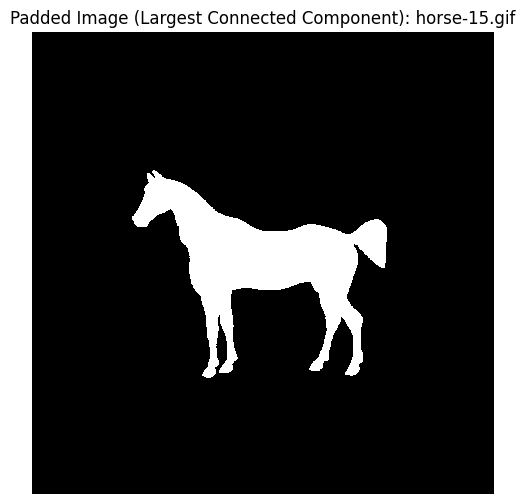

In [24]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.ndimage import label

def filter_to_largest_cc(img_array):
    """
    Filters the binary image to keep only the largest connected component.
    This function first creates a boolean mask identifying white pixels (values > 0),
    then labels connected regions using an 8-connected neighborhood. It determines which 
    connected component is largest (by pixel count) and returns a new image where only 
    that component is retained as white (1), while all other pixels are set to 0.
    
    Parameters:
        img_array : np.array
            Input binary image array (with values 0 or 1, or >0 for white).
    
    Returns:
        np.array
            A binary image with only the largest connected white component.
    """
    # Create a boolean mask for white pixels.
    mask = img_array > 0
    # Label connected components using an 8-connected structure.
    labeled_array, num_features = label(mask, structure=np.ones((3, 3)))
    
    # If there are no white pixels (no connected component), return an array of zeros.
    if num_features == 0:
        return np.zeros_like(img_array)
    
    # Count the number of pixels in each connected component.
    component_sizes = np.bincount(labeled_array.ravel())
    
    # The background is labeled 0, so find the largest component among the non-background labels.
    if len(component_sizes) > 1:
        largest_component = np.argmax(component_sizes[1:]) + 1  # +1 to adjust for the background index
    else:
        return np.zeros_like(img_array)
    
    # Create a new image that retains only the largest connected component.
    filtered_img = (labeled_array == largest_component)
    return filtered_img.astype(img_array.dtype)

def pad_image_to_square(img_array, target_length):
    """
    Pads a binary image (values 0 or 1) to a square of size target_length x target_length.
    The image is padded with zeros (black pixels) so that the average coordinate of
    all white pixels (pixels with a value > 0) is centered in the new image.
    
    Parameters:
        img_array : np.array
            Input binary image.
        target_length : int
            The size of the square output image.
    
    Returns:
        np.array
            The padded square image.
    """
    # Get the original dimensions.
    orig_height, orig_width = img_array.shape[0:2]
    
    # Identify white pixels (values > 0)
    white_pixels = np.argwhere(img_array > 0)
    if white_pixels.size == 0:
        # If there are no white pixels, default to the center of the original image.
        centroid = np.array([orig_height / 2.0, orig_width / 2.0])
    else:
        # Compute the centroid of the white pixels.
        centroid = white_pixels.mean(axis=0)
    
    # Define the center of the target square.
    target_center = np.array([target_length / 2.0, target_length / 2.0])
    # Compute the offset needed to shift the white pixel centroid to the center.
    offset = np.round(target_center - centroid).astype(int)
    
    # Create a new square image of target_length filled with zeros (black).
    new_img = np.zeros((target_length, target_length), dtype=img_array.dtype)
    
    # Compute destination coordinates for pasting.
    paste_row = offset[0]
    paste_col = offset[1]
    dest_row_start = max(0, paste_row)
    dest_col_start = max(0, paste_col)
    dest_row_end = min(target_length, paste_row + orig_height)
    dest_col_end = min(target_length, paste_col + orig_width)
    
    # Calculate the source region from the original image that is to be copied.
    src_row_start = max(0, -paste_row)
    src_col_start = max(0, -paste_col)
    src_row_end = src_row_start + (dest_row_end - dest_row_start)
    src_col_end = src_col_start + (dest_col_end - dest_col_start)
    
    # Paste the computed region into the new padded image.
    new_img[dest_row_start:dest_row_end, dest_col_start:dest_col_end] = \
        img_array[src_row_start:src_row_end, src_col_start:src_col_end]
    
    return new_img

# --- Sample Plot Code Using the Filter Function ---

# Example: choose a particular image file in the current directory.
filename = "horse-15.gif"  # Replace with an actual file name from your folder.
file_path = os.path.join(".", filename)

# Read the image using PIL and convert it to a NumPy array.
with Image.open(file_path) as img:
    try:
        # If the GIF is animated, take only the first frame.
        img.seek(0)
    except EOFError:
        pass
    img_array = np.array(img)

# First, filter the image to keep only the largest connected component.
filtered_img = filter_to_largest_cc(img_array)

# For demonstration, determine a target length.
# In full processing, this might be computed as (max_dim + 10).
target_length = 1182

# Pad the filtered image.
padded_img = pad_image_to_square(filtered_img, target_length)

# Plot the padded image.
plt.figure(figsize=(6, 6))
plt.imshow(padded_img, cmap="gray", interpolation="nearest")
plt.title(f"Padded Image (Largest Connected Component): {filename}")
plt.axis("off")
plt.show()


Computing 100×100 pairwise Wasserstein distances in parallel…


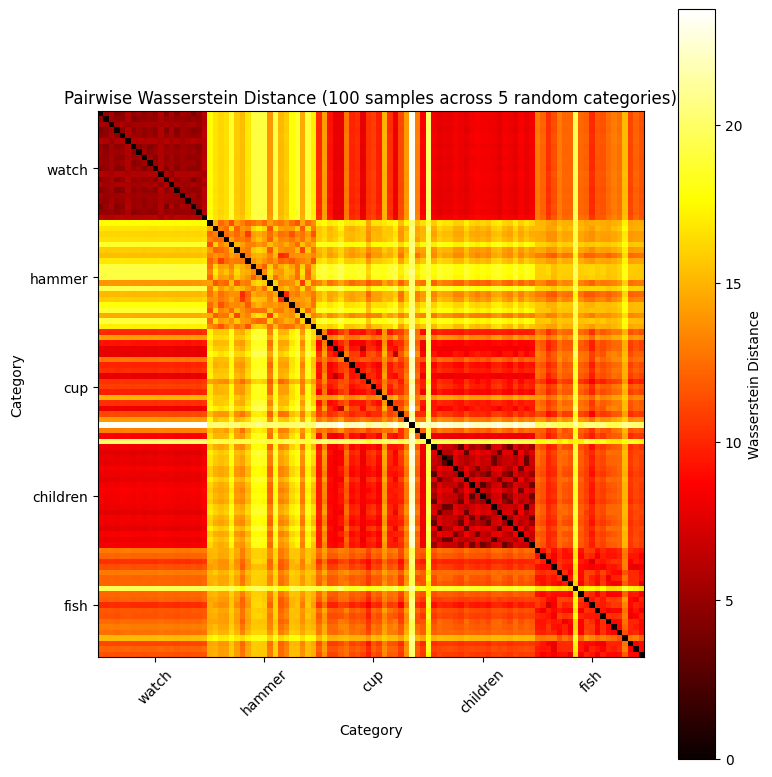

In [29]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed

# -----------------------------
# SETTINGS
# -----------------------------
n_categories = 5           # ← Change this to pick n random categories
samples_per_cat = 20       # ← Change this to pick m samples per chosen category

random.seed(42)

# -----------------------------
# 1. Assume these are loaded:
#    - ECT_all : list of k×N arrays
#    - labels_all : list of (category, number) tuples
# -----------------------------
all_categories = list({cat for cat, _ in labels_all})

# 2. Randomly select n_categories
selected_cats = random.sample(all_categories, n_categories)

# 3. Gather indices of each selected category and sample
indices_by_cat = {
    cat: [i for i, (cat_i, _) in enumerate(labels_all) if cat_i == cat]
    for cat in selected_cats
}

chosen_indices = []
for cat in selected_cats:
    available = indices_by_cat[cat]
    k = min(samples_per_cat, len(available))
    chosen = random.sample(available, k)
    chosen_indices.extend(chosen)

# 4. Sort so that blocks of each category stay together
chosen_indices.sort(key=lambda i: labels_all[i][0])

# 5. Subset your features & labels
subset = [ECT_all[i] for i in chosen_indices]
labels_subset = [labels_all[i] for i in chosen_indices]

# -----------------------------
# Parallel Wasserstein routines
# -----------------------------
def wasserstein_distance(emp1, emp2, p=2, delta_x=1.0):
    cost = cdist(emp1, emp2, metric='minkowski', p=p) * (delta_x ** (1.0 / p))
    ri, ci = linear_sum_assignment(cost)
    return np.mean(cost[ri, ci] ** p) ** (1.0 / p)

def compute_row(i, measures):
    n = len(measures)
    row = np.zeros(n)
    for j in range(i, n):
        row[j] = wasserstein_distance(measures[i], measures[j])
    return i, row

def compute_distance_matrix_parallel(measures):
    n = len(measures)
    results = Parallel(n_jobs=-1)(
        delayed(compute_row)(i, measures) for i in range(n)
    )
    D = np.zeros((n, n))
    for i, row in results:
        D[i, i:] = row[i:]
        D[i:, i] = row[i:]
    return D

# -----------------------------
# Compute & plot
# -----------------------------
print(f"Computing {len(subset)}×{len(subset)} distances for {n_categories} categories…")
D = compute_distance_matrix_parallel(subset)

plt.figure(figsize=(8, 8))
plt.imshow(D, cmap="hot", interpolation="nearest")
plt.colorbar(label="Wasserstein Distance")
plt.title(f"Pairwise Distances ({n_categories} categories × {samples_per_cat} samples)")

# tick every samples_per_cat
tick_pos = [samples_per_cat//2 + i*samples_per_cat for i in range(n_categories)]
plt.xticks(tick_pos, selected_cats, rotation=45)
plt.yticks(tick_pos, selected_cats)
plt.xlabel("Category")
plt.ylabel("Category")
plt.tight_layout()
plt.show()


## classification

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns

# ---------- Provided Distance Functions ----------
def wasserstein_distance(empirical1, empirical2, p=2, delta_x=1.0):
    """
    Compute the Wasserstein distance between two empirical measures,
    each represented as a k x N array (each row is a function sampled at N points),
    incorporating the delta_x factor for uniformly sampled points.
    """
    cost_matrix = cdist(empirical1, empirical2, metric='minkowski', p=p) * (delta_x ** (1.0 / p))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    avg_cost_p = np.mean(cost_matrix[row_ind, col_ind] ** p)
    return avg_cost_p ** (1.0 / p)

def compute_row(i, measures, p=2, delta_x=1.0):
    """
    Computes the i-th row of the distance matrix.
    """
    n = len(measures)
    row = np.zeros(n)
    for j in range(i, n):
        d = wasserstein_distance(measures[i], measures[j], p=p, delta_x=delta_x)
        row[j] = d
    return i, row

def compute_distance_matrix_parallel(measures, p=2, delta_x=1.0):
    """
    Computes the symmetric pairwise distance matrix in parallel.
    """
    n = len(measures)
    results = Parallel(n_jobs=-1)(delayed(compute_row)(i, measures, p, delta_x) for i in range(n))
    distance_matrix = np.zeros((n, n))
    for i, row in results:
        distance_matrix[i, i:] = row[i:]
        distance_matrix[i:, i] = row[i:]
    return distance_matrix

# ---------- Data and Labels Setup ----------
# Assume that ECT_all and labels_all have been computed previously.
# For this example, we use a subset of 200 entries.
subset = ECT_all              # list of k x N arrays (ECT features)
labels_subset = labels_all     # list of tuples (category, number)

# Extract the category (first element of each tuple) as target labels.
categories = np.array([label[0] for label in labels_subset])

# ---------- Compute the Pairwise Distance Matrix in Parallel ----------
print("Computing pairwise Wasserstein distances in parallel...")
distance_matrix = compute_distance_matrix_parallel(subset, p=2, delta_x=1.0)

# Optional: Plot the distance matrix heatmap (with groups of 20 assumed per category)
plt.figure(figsize=(10, 8))
heat = plt.imshow(distance_matrix, cmap="hot", interpolation="nearest")
plt.colorbar(heat, label="Wasserstein Distance")
plt.title("Pairwise Wasserstein Distance Heatmap (First 200 ECT Entries)")

group_size = 20
n_groups = len(subset) // group_size
tick_positions = [group_size//2 + i*group_size for i in range(n_groups)]
group_labels = [categories[i*group_size] for i in range(n_groups)]
plt.xticks(tick_positions, group_labels, rotation=45)
plt.yticks(tick_positions, group_labels)
plt.xlabel("Category")
plt.ylabel("Category")
plt.show()

# ---------- Convert the Distance Matrix to an RBF Kernel Matrix ----------
sigma = np.median(distance_matrix)  # Use the median distance for sigma.
kernel_matrix = np.exp(- (distance_matrix ** 2) / (2 * sigma ** 2))

# ---------- SVM Classification Using Precomputed Kernel ----------
# First, we split the indices for training and testing.
indices = np.arange(len(subset))
train_idx, test_idx, y_train, y_test = train_test_split(
    indices, categories, test_size=0.3, random_state=42, stratify=categories
)

# For precomputed kernels, we create the corresponding sub-matrices.
K_train = kernel_matrix[np.ix_(train_idx, train_idx)]
K_test = kernel_matrix[np.ix_(test_idx, train_idx)]

# Now, perform a parameter sweep (grid search) for the SVC parameter C.
param_grid = {"C": [ 0.01, 0.1, 1, 10, 100]}

# Create the SVM with precomputed kernel.
svc = SVC(kernel='precomputed', random_state=42)

# Use GridSearchCV with 5-fold cross-validation on the training kernel.
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(K_train, y_train)

print("Best parameters found:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

# ---------- Evaluate the Best Estimator on Test Data ----------
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(K_test)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ---------- Optional: Plot the Confusion Matrix ----------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(categories),
            yticklabels=np.unique(categories))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Computing pairwise Wasserstein distances in parallel...


KeyboardInterrupt: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# ---------------------------------------------------------
# ASSUMPTIONS:
# - kernel_matrix is already computed from a previous pipeline 
#   (e.g., from a pairwise Wasserstein distance matrix converted to an RBF kernel).
#
# - ECT_all is a list of ECT feature arrays.
#
# - labels_all is a list of tuples (category, number).
# ---------------------------------------------------------

# For demonstration purposes, we take the first 200 entries.
subset = ECT_all
labels_subset = labels_all

# Extract the target labels (categories) from labels_subset.
categories = np.array([label[0] for label in labels_subset])

# --------------- Random Forest Classifier ---------------
# For random forest, we use the flattened representations of ECT features.
# Assume flattened_all is computed as:
flattened_all = [img.flatten() for img in ECT_all]
# Use the first 200 entries.
X_rf = np.array(flattened_all)
y_rf = categories

# Split data for Random Forest.
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.3, random_state=42, stratify=y_rf
)

# Parameter grid for Random Forest as provided.
param_grid_rf = {
    'n_estimators': [50, 100, 200, 500, 1000, 5000],
    'max_depth': [3, 5, 7, 20, None],
    'min_samples_split': [2, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Set up and run grid search for Random Forest.
rf_clf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf_clf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train_rf, y_train_rf)

print("Random Forest Best Parameters:", grid_search_rf.best_params_)
print("Random Forest Best CV Score:", grid_search_rf.best_score_)

# Evaluate best Random Forest on the test set.
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test_rf)

print("Random Forest Test Accuracy:", accuracy_score(y_test_rf, y_pred_rf))
print("\nRandom Forest Classification Report:\n", classification_report(y_test_rf, y_pred_rf))

# Plot the Random Forest confusion matrix.
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_rf), yticklabels=np.unique(y_rf))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Random Forest Confusion Matrix")
plt.show()
